In [76]:
# importing libraries
import pandas as pd
import cv2
import numpy as np
import skimage.io as io
from matplotlib import pyplot as plt

In [77]:
# Setting RGB color scheme for determining the ripeness status later on

UNRIPE = np.array([[143, 169, 65]])
SEMI_RIPE = np.array([[213, 209, 122]])
RIPE = np.array([[244, 219, 100]])
HALF_ROTTEN = np.array([[234, 171, 64]])
ROTTEN = np.array([[46, 37, 34]])

# These are the matching grayscale values

G_UNRIPE = np.array([146])
G_SEMI_RIPE = np.array([200])
G_RIPE = np.array([213])
G_HALF_ROTTEN = np.array([178])
G_ROTTEN = np.array([39])


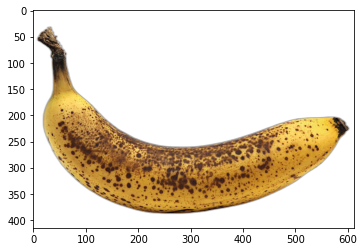

In [78]:
# steps 1+ 2: reading the banana image and  removing the background using rembg

from rembg import remove
from PIL import Image

input_path = r'C:\Users\zinge\Documents\BSc\Y3\S1\image_analysis\final project\dataset\overripe\istockphoto-184952247-612x612.jpg' # input image path
output_path = 'output.png' # output image path

input = Image.open(input_path) # load image
output = remove(input) # remove background
output.save(output_path) # save image

plt.imshow(output)

png shape: (415, 612, 4)


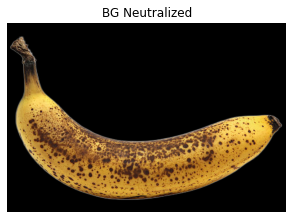

In [79]:
bg_removed = np.array(output)
print("png shape:",bg_removed.shape)



# converting from png to jpg

new  = bg_removed[:,:,:3]
#print("jpg shape:",new.shape)
plt.figure(figsize=(5,5))
plt.title("BG Neutralized")
plt.axis('off')
plt.imshow(new)

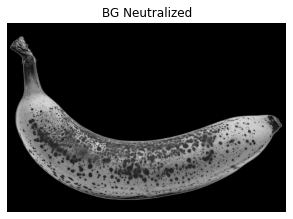

In [80]:
# converting to grayscale

bg_removed_gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5,5))
plt.title("BG Neutralized")
plt.axis('off')
plt.imshow(bg_removed_gray, cmap="gray")

In [81]:
# step 3: pre-process the image before segmentation

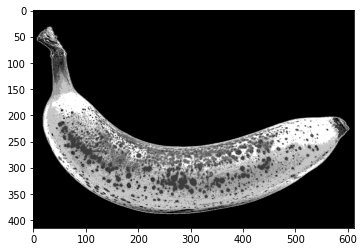

In [82]:
# step 4: K-means segmentation

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = bg_removed_gray.reshape((-1, 1))
# convert to float
pixel_values = np.float32(pixel_values)

# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# number of clusters (K)
k = 6
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(bg_removed_gray.shape)
# show the image
plt.imshow(segmented_image,cmap="gray")
plt.show()

In [83]:
# step 5: getting the centers of the clusters (the weighted average of the pixels in each cluster)

# count how many pixels are in each cluster
pixel_counts = np.bincount(labels)

# convert ceneters to a list of integers
centers = centers.tolist()

# convert each element in the list to an integer (from a list of lists)
for i in range(len(centers)):
    centers[i] = int(centers[i][0])

# create a dataframe of the pixel counts, the centers and their weighted average
df = pd.DataFrame({'centers': centers, 'pixel_counts':pixel_counts, 'real_product':pixel_counts*centers})

# remove the line with the [0] center (the background)
df = df.drop(df[df.centers==0].index)

df

,centers,pixel_counts,real_product
1,170,10305,1751850
2,106,18460,1956760
3,74,14288,1057312
4,132,22251,2937132
5,41,11187,458667


In [84]:
# step 6: classifying each center to its closest grayscale value

grayscale_values = [146, 200, 213, 178, 39] # the grayscale values of the colors

def closest(lst, K): # function to find the closest grayscale value to each center
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

df['closest_grayscale'] = df['centers'].apply(lambda x: closest(grayscale_values, x)) # apply the function to the centers

# calculating the desired product
df['desired_product'] = df['pixel_counts']*df['closest_grayscale']

# adding a column with the percentage of the total pixels in each cluster
df['percentage'] = df['pixel_counts']/df['pixel_counts'].sum()*100

# changing the order of the columns
df = df[['centers', 'closest_grayscale', 'pixel_counts','percentage', 'real_product', 'desired_product']]

df

,centers,closest_grayscale,pixel_counts,percentage,real_product,desired_product
1,170,178,10305,13.472173,1751850,1834290
2,106,146,18460,24.133558,1956760,2695160
3,74,39,14288,18.679322,1057312,557232
4,132,146,22251,29.089697,2937132,3248646
5,41,39,11187,14.625250,458667,436293


In [89]:
# creating a new datafram with everything but thr centers column
df2 = df.drop(['centers'], axis=1)

# add a column with the ripening level
df2['ripening_level'] = df2['closest_grayscale'].apply(lambda x: 'unripe' if x == 146 else 'semi-ripe' if x == 200 else 'ripe' if x == 213 else 'half-rotten' if x == 178 else 'rotten')

# group by ripening level and sum the percentages
df2 = df2.groupby(['ripening_level']).sum()

df2

,closest_grayscale,pixel_counts,percentage,real_product,desired_product
ripening_level,,,,,
half-rotten,178,10305,13.472173,1751850,1834290
rotten,78,25475,33.304572,1515979,993525
unripe,292,40711,53.223255,4893892,5943806


In [92]:
# deciding the ripeness status
# the nearest of the desired products to the average of the real products is the ripeness status

# the average of the real products
real_product_avg = df2['real_product'].sum()/len(df2)

# finding the nearest of the desired products to the average of the real products
nearest = closest(df2['desired_product'].tolist(), real_product_avg)

# finding the ripeness status
ripeness_status = df2[df2['desired_product']==nearest].index[0]

print("The banana is",ripeness_status)

The banana is half-rotten


Text(0, 0.5, 'Ripeness Level')

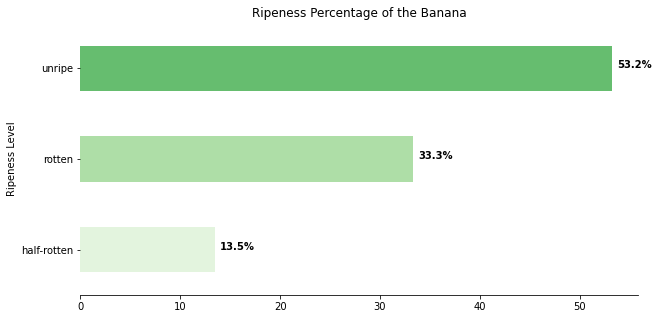

In [96]:
# plot the percentages only (without the grayscale values), horizontal bar chart
df2['percentage'].plot(kind='barh', color='darkgoldenrod', title='Ripeness Percentage of the Banana', figsize=(10,5))

#remove spines
for s in ['top', 'right', 'left']:
    plt.gca().spines[s].set_visible(False)

# make the bars with a gradient color
for i, v in enumerate(df2['percentage']): 
    # add the percentages on top of the bars, rounded to 1 decimal
    plt.gca().text(v+0.5, i, str(round(v,1))+'%', color='black', fontweight='bold')
    # make the bars with a gradient color
    plt.gca().patches[i].set_facecolor(plt.cm.Greens(v/100))

# name the y axis "Ripeness Level"
plt.gca().set_ylabel('Ripeness Level')